# Hurricane Track Specific Protection Maps
This notebook analyzes the spatial autocorrelation of water level data across different scenarios and horizons.

In [1]:
import sys
sys.path.append('/mnt/Work/LaGonaveFM/') # or use path 
sys.path.append('/home/aesgeorges/LaGonaveFM/')
from codebase.figures import *
from codebase.tools import *

import cmocean
import numpy as np
import netCDF4 as netcdf
import matplotlib.pyplot as plt
import matplotlib.colors as mplcolors
from tqdm import tqdm
#from kalpana.plotting import plot_nc
#from kalpana.export import fort14togdf
#from kalpana.ADCIRC_tools import extract_ts_from_nc
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib as mpl
import geopandas as gpd

import pandas as pd
import xarray as xr
import rasterio as rio
import rioxarray as rxr

from tqdm import tqdm
import xarray as xr
import rasterio
from scipy.spatial import cKDTree

import fiona
from shapely.geometry import shape

#import scienceplots
#plt.style.use(['science', 'ieee'])

#from cmcrameri import cm as cmc

In [2]:
mangrove_scenario = 'Gonave_SLR_mangrove'
nomangrove_scenario = 'Gonave_SLR_nomangrove'
root = f'../sims/{mangrove_scenario}/'
root_t2 = f'../sims/{mangrove_scenario}_t2/'
root_t3 = f'../sims/{mangrove_scenario}_t3/'
root_nomangrove = f'../sims/{nomangrove_scenario}/'
root_nomangrove_t2 = f'../sims/{nomangrove_scenario}_t2/'
root_nomangrove_t3 = f'../sims/{nomangrove_scenario}_t3/'

In [3]:
cities_extents = '../datasets/other/cities.shp'
# Read the shapefile using fiona
with fiona.open(cities_extents, 'r') as src:
    cities = pd.DataFrame([feature['properties'] for feature in src])
    cities['geometry'] = [shape(feature['geometry']) for feature in src]

cities_gdf = gpd.GeoDataFrame(cities, geometry='geometry')

In [4]:
scenarios = ['SSP1', 'SSP2', 'SSP3', 'SSP5']
horizons = [2030, 2050, 2070, 2100]

data = {}
data_nomangrove = {}

def load_data(scenario, horizon, dict, root):

    for scenario in scenarios:
        dict[scenario] = {}
        for horizon in horizons:
            file_path = f'{root}{scenario}_{horizon}/hotstart/maxele.63.nc'
            dict[scenario][horizon] = netcdf.Dataset(file_path, 'r')
    return dict

data = load_data(scenarios, horizons, data, root)
data_nomangrove = load_data(scenarios, horizons, data_nomangrove, root_nomangrove)

In [11]:
def read_mesh_coordinates(mesh_path):
    mesh_points = []
    
    with open(mesh_path, 'r') as f:
        # Read header line (ignored)
        f.readline()
        
        # Read number of elements and nodes
        line = f.readline().split()
        num_elements = int(line[0])
        num_nodes = int(line[1])
        
        # Read nodal coordinates
        for i in range(num_nodes):
            line = f.readline().split()
            node_id = int(line[0])
            x = float(line[1])
            y = float(line[2])
            # z = float(line[3])  # Not needed for this function
            
            mesh_points.append([x, y])
    
    return np.array(mesh_points)

def expand_flooding_hand_realistic(adcirc_data, dem_path, mesh_path):
    import xarray as xr
    import rasterio
    from scipy.spatial import cKDTree
    
    # Read data
    water_elevation = adcirc_data['zeta_max'][:]
    
    with rasterio.open(dem_path) as dem:
        elevation = dem.read(1)
        transform = dem.transform
        crs = dem.crs
    
    # Read mesh points
    mesh_points = read_mesh_coordinates(mesh_path)
    
    # Clean data
    valid_mask = ~np.isnan(water_elevation)
    mesh_points_clean = mesh_points[valid_mask]
    water_elev_clean = water_elevation[valid_mask]
    
    # Get DEM grid coordinates
    rows, cols = np.indices(elevation.shape)
    x, y = rasterio.transform.xy(transform, rows.ravel(), cols.ravel())
    grid_coords = np.column_stack([x, y])
    
    # IDW interpolation
    tree = cKDTree(mesh_points_clean)
    
    # Find nearest neighbors with distance limit
    distances, indices = tree.query(grid_coords, k=5, distance_upper_bound=2000)
    
    # Initialize result
    water_elev_grid = np.zeros(len(grid_coords))
    
    for i in tqdm(range(len(grid_coords)), desc="Interpolating water levels"):
        # Get valid distances/indices (not inf)
        valid = distances[i] < np.inf
        if np.sum(valid) > 0:
            d = distances[i][valid]
            idx = indices[i][valid]
            
            # IDW with adaptive power based on mesh resolution
            power = 1.5  # Good balance for ADCIRC meshes
            weights = 1.0 / d**power
            weights /= weights.sum()
            
            water_elev_grid[i] = np.sum(weights * water_elev_clean[idx])
        else:
            # No nearby points - use global average as fallback
            water_elev_grid[i] = np.mean(water_elev_clean)
    
    # Reshape and calculate inundation
    water_elev_grid = water_elev_grid.reshape(elevation.shape)
    inundation_depth = np.maximum(0, water_elev_grid - elevation)
    
    # Handle DEM NaNs
    inundation_depth[np.isnan(elevation)] = np.nan
    
    return inundation_depth, transform, crs

In [6]:
~np.isnan(data['SSP1'][2030]['zeta_max'][:])

masked_array(data=[--, True, True, ..., True, True, True],
             mask=[ True, False, False, ..., False, False, False],
       fill_value=-99999.0)

In [12]:
dempath = "../datasets/rasters/GrandPierre_fix.tif"
mesh_path = "../sims/Gonave_SLR_mangrove/S0/fort.14"

inundation_depth, transform, crs = expand_flooding_hand_realistic(data['SSP5'][2100], dempath, mesh_path)

Interpolating water levels: 100%|██████████| 2223148/2223148 [02:03<00:00, 18034.56it/s]


In [14]:
inundation_depth_nm, transform_nm, crs_nm = expand_flooding_hand_realistic(data_nomangrove['SSP5'][2100], dempath, mesh_path)

Interpolating water levels: 100%|██████████| 2223148/2223148 [02:04<00:00, 17793.90it/s]


In [ ]:
import matplotlib.patheffects as path_effects

def compute_diff(base_mangrove, base_nomangrove):
    base_mangrove = np.where(np.isnan(base_mangrove), np.nan, base_mangrove)
    base_nomangrove = np.where(np.isnan(base_nomangrove), np.nan, base_nomangrove)

    diff = base_mangrove - base_nomangrove
    return diff


def plot_diff(diff, title):
    fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': ccrs.PlateCarree()}, 
                    constrained_layout=True)
    # Convert from NGVD29 to NAVD88 using an approximate offset (https://pubs.usgs.gov/sir/2010/5040/section.html)
    norm = mplcolors.TwoSlopeNorm(vmin=-5, vcenter=0, vmax=5)

    extent = [-72.85, -72.58, 19.23, 19.5]
    im = ax.imshow(diff, extent=extent, cmap=cmocean.cm.balance, norm=norm, zorder=10)
    cbar = plt.colorbar(im, ax=ax, label='Difference in flood depth [m]')
    cbar.set_label('Difference in flood depth [m]', fontsize=12)
    cbar.ax.tick_params(labelsize=10)
    cbar.ax.set_yscale('linear')

    cities_gdf.plot(ax=ax, edgecolor='white', facecolor='gray', alpha=0.1, linestyle='--', zorder=10)
    cities_gdf.plot(ax=ax, edgecolor='white', facecolor='none', linestyle='--', zorder=10)
    cities = ['Desdunes', "L'Estere", 'Gonaives']
    for x, y, label in zip(cities_gdf.geometry.centroid.x, cities_gdf.geometry.centroid.y, cities):
        t = ax.text(
            x, y, str(label),
            fontsize=10,
            color='white',
            ha='center',
            va='center',
            zorder=11,
        )
        t.set_path_effects([path_effects.Stroke(linewidth=1, foreground='black'),
                       path_effects.Normal()])

    ax.set_xlim(-72.85, -72.58)
    ax.set_ylim(19.23, 19.5)

    print(diff.min(), diff.max())  

    ax.set_title(title, fontsize=16)

    #coastline = cf.GSHHSFeature(scale='full', levels=[1,2,3,4], alpha=1.0, edgecolor='black')
    #ax.add_feature(coastline, zorder=1)
    #ax.add_feature(cf.BORDERS, linestyle='--', alpha=0.5)

    gl = ax.gridlines(draw_labels=True, alpha=0.5, linestyle='--', zorder=10) 
    gl.top_labels = False
    gl.right_labels = False
    # Export the plot with a transparent background
    #plt.savefig(f"exports/figures/{title}.png", dpi=600, bbox_inches='tight', transparent=True)

In [33]:
diff = compute_diff(inundation_depth, inundation_depth_nm)
diff

array([[-0.00025486, -0.0002551 , -0.00025532, ...,         nan,
                nan,         nan],
       [-0.00025545, -0.0002557 , -0.00025594, ...,         nan,
                nan,         nan],
       [-0.00025604, -0.00025631, -0.00025656, ...,         nan,
                nan,         nan],
       ...,
       [-0.00015599, -0.00015642, -0.00015686, ...,         nan,
                nan,         nan],
       [-0.00015599, -0.00015643, -0.00015688, ...,         nan,
                nan,         nan],
       [-0.00015597, -0.00015643, -0.0001569 , ...,         nan,
                nan,         nan]])

nan nan


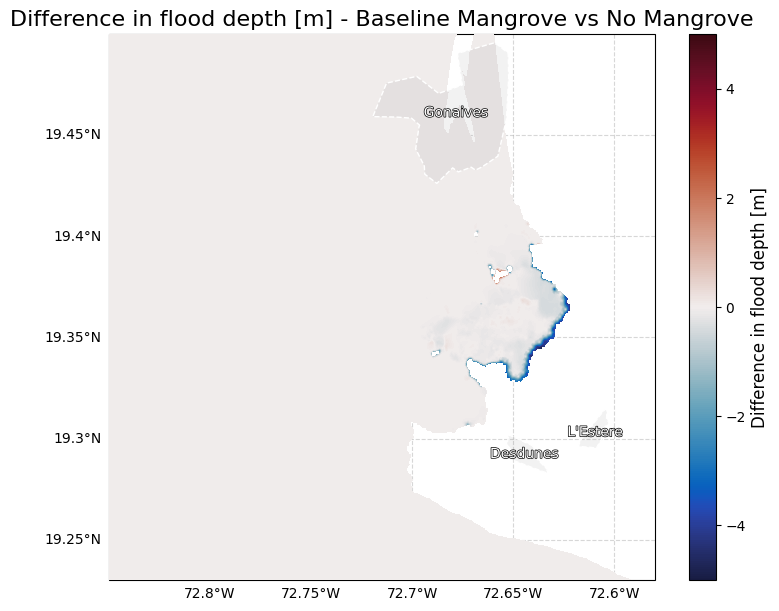

In [38]:
plot_diff(diff, 'Difference in flood depth [m] - Baseline Mangrove vs No Mangrove')

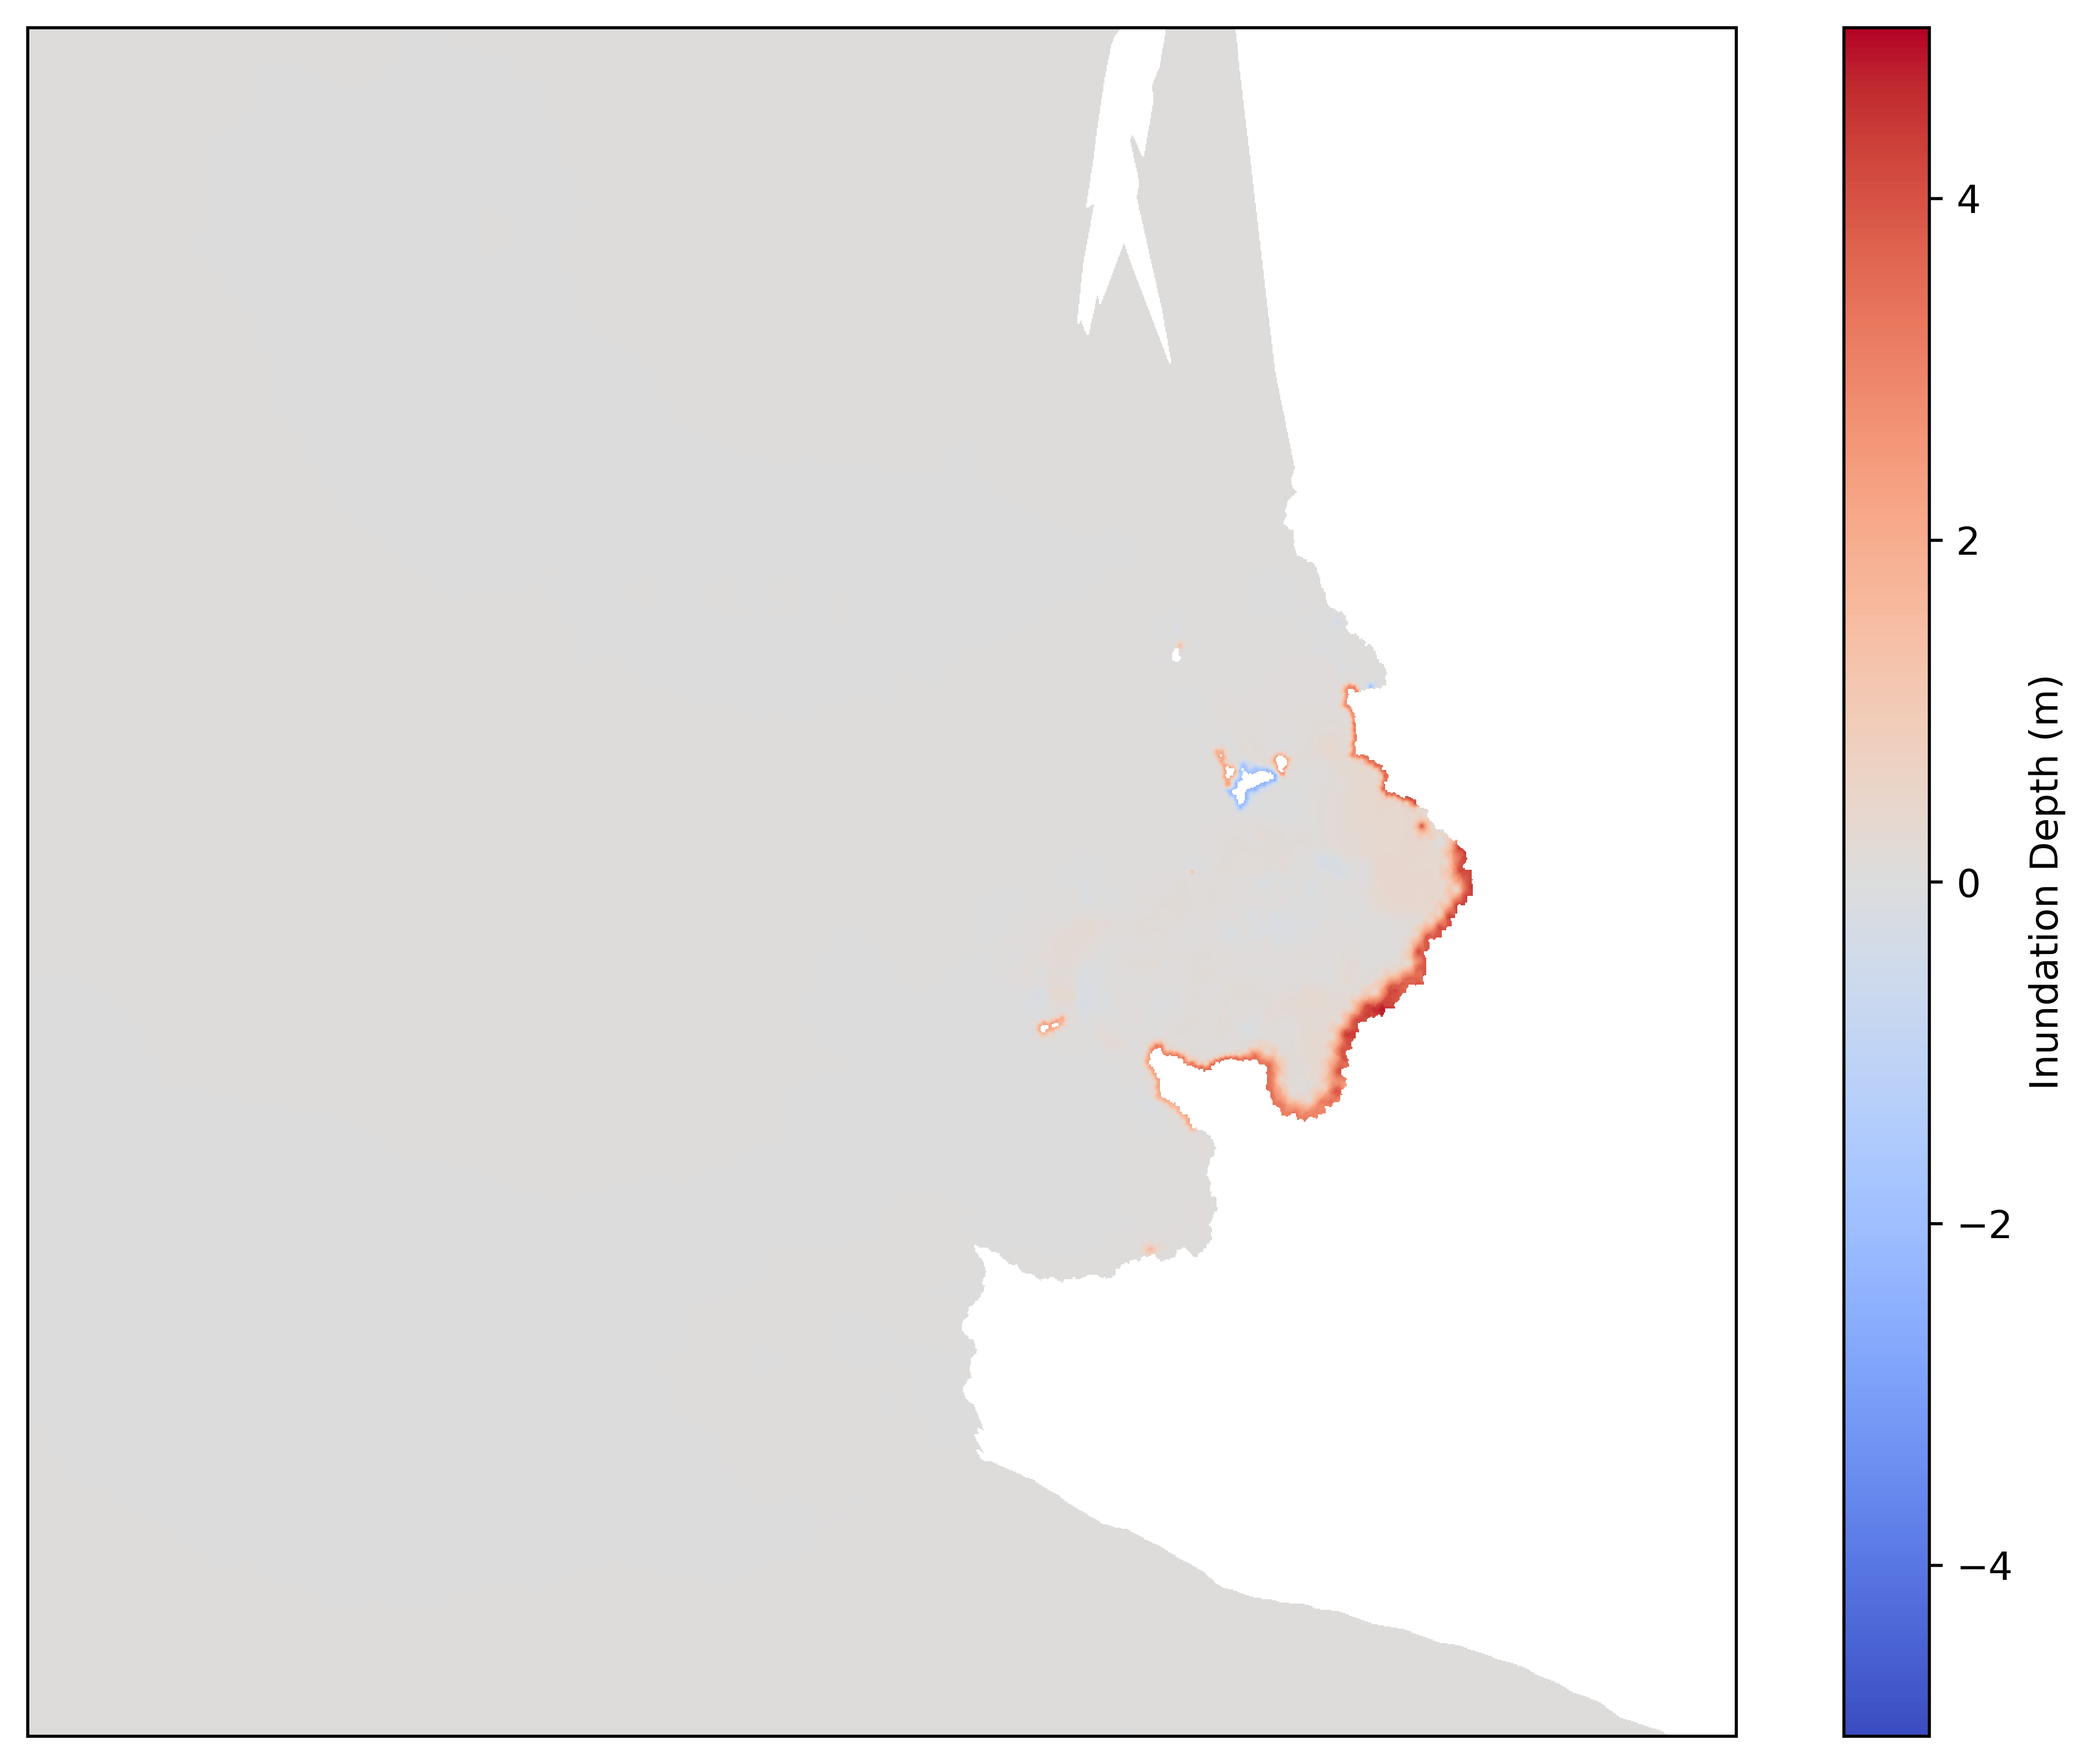

In [26]:
extent = [-72.85, -72.6, 19.25, 19.5]
fig, ax = plt.subplots(figsize = (10,8), dpi=500, subplot_kw={'projection': ccrs.PlateCarree()})
im = ax.imshow(inundation_depth_nm - inundation_depth, extent=extent, aspect=ax.get_aspect(), transform=ax.transAxes, cmap='coolwarm', vmin=-5., vmax=5)


plt.colorbar(im, ax=ax, orientation='vertical', label='Inundation Depth (m)')

ax.set_extent(extent)

ax.top_labels = False
ax.right_labels = False
ax.xlocator = mpl.ticker.MaxNLocator(nbins=5)
ax.ylocator = mpl.ticker.MaxNLocator(nbins=5)